In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Enable memory growth if using GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

2024-11-07 13:51:26.697664: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-07 13:51:26.706604: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-07 13:51:26.714269: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-07 13:51:26.716487: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 13:51:26.722919: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Load the data
df = pd.read_csv('../data/raw/Train.csv')

# Convert Time to datetime with explicit format (day first)
df['Time'] = pd.to_datetime(df['Time'], format='%d-%m-%Y %H:%M')

# Select features (excluding Location and index column)
feature_columns = ['Temp_2m', 'RelHum_2m', 'DP_2m', 'WS_10m', 'WS_100m', 
                   'WD_10m', 'WD_100m', 'WG_10m', 'Power']

# Create feature matrix
data = df[feature_columns].values

# Determine split indices based on the original data length
total_samples = data.shape[0]
train_end = int(0.7 * total_samples)
val_end = train_end + int(0.15 * total_samples)

# Split the data
train_data = data[:train_end]
val_data = data[train_end:val_end]
test_data = data[val_end:]

# Initialize scaler
scaler = StandardScaler()

# Fit the scaler on the training data (excluding the target column)
scaled_train_features = scaler.fit_transform(train_data[:, :-1])

# Transform validation and test data
scaled_val_features = scaler.transform(val_data[:, :-1])
scaled_test_features = scaler.transform(test_data[:, :-1])

# Combine scaled features with the target variable
scaled_train_data = np.column_stack((scaled_train_features, train_data[:, -1]))
scaled_val_data = np.column_stack((scaled_val_features, val_data[:, -1]))
scaled_test_data = np.column_stack((scaled_test_features, test_data[:, -1]))

print("Data shapes after scaling and splitting:")
print(f"Training data shape: {scaled_train_data.shape}")
print(f"Validation data shape: {scaled_val_data.shape}")
print(f"Test data shape: {scaled_test_data.shape}")

Data shapes after scaling and splitting:
Training data shape: (98112, 9)
Validation data shape: (21024, 9)
Test data shape: (21024, 9)


In [3]:
def create_windows(data, window_size=12, target_col=-1):
    """
    Create sliding windows from time series data.
    
    Args:
        data: numpy array of shape (n_samples, n_features)
        window_size: number of time steps to use for input
        target_col: index of target column (default: -1 for last column)
    
    Returns:
        X: numpy array of shape (n_samples - window_size, window_size, n_features)
        y: numpy array of shape (n_samples - window_size,)
    """
    X, y = [], []
    
    for i in range(len(data) - window_size):
        # Get window of all features
        window = data[i:(i + window_size)]
        # Target is the Power value at the next time step
        target = data[i + window_size, target_col]
        
        X.append(window)
        y.append(target)
    
    return np.array(X), np.array(y)

# Create windows for training data
X_train, y_train = create_windows(scaled_train_data, window_size=12)

# Create windows for validation data
X_val, y_val = create_windows(scaled_val_data, window_size=12)

# Create windows for test data
X_test, y_test = create_windows(scaled_test_data, window_size=12)

print("\nWindowed dataset shapes:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape}")
print(f"y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape}")
print(f"y_test:  {y_test.shape}")


Windowed dataset shapes:
X_train: (98100, 12, 9)
y_train: (98100,)
X_val:   (21012, 12, 9)
y_val:   (21012,)
X_test:  (21012, 12, 9)
y_test:  (21012,)


In [4]:
# Calculate input dimensions
n_timesteps = X_train.shape[1]  # 12
n_features = X_train.shape[2]   # 9
input_dim = n_timesteps * n_features  # 108

# Create model
model = Sequential([
    # Flatten the input (12 timesteps × 9 features = 108)
    Flatten(input_shape=(n_timesteps, n_features)),
    
    # Hidden layers
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    
    # Output layer (single value prediction)
    Dense(1, activation='sigmoid')  # sigmoid because Power is normalized 0-1
])

# Compile model
model.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    loss='mse',
    metrics=['mae', 'mse']  # tracking both MAE and MSE
)

# Print model summary
model.summary()

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

/home/dkat/courses/computational-intelligence/.venv/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1730987587.734216   40216 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730987587.734267   40216 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730987587.734282   40216 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730987587.850611   40216 cuda_executor.cc:1001] could not

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 108)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         6,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,089 (35.50 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


I0000 00:00:1730987633.579975   40794 service.cc:146] XLA service 0x7ff664016790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730987633.580004   40794 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-11-07 13:53:53.610244: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-07 13:53:53.708254: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 216/3066 ━━━━━━━━━━━━━━━━━━━━ 2s 784us/step - loss: 0.0633 - mae: 0.1949 - mse: 0.0631

I0000 00:00:1730987634.230297   40794 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3066/3066 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0324 - mae: 0.1370 - mse: 0.0324 - val_loss: 0.0108 - val_mae: 0.0810 - val_mse: 0.0108
Epoch 2/100
3066/3066 ━━━━━━━━━━━━━━━━━━━━ 3s 907us/step - loss: 0.0124 - mae: 0.0856 - mse: 0.0124 - val_loss: 0.0068 - val_mae: 0.0648 - val_mse: 0.0068
Epoch 3/100
3066/3066 ━━━━━━━━━━━━━━━━━━━━ 3s 901us/step - loss: 0.0086 - mae: 0.0715 - mse: 0.0086 - val_loss: 0.0052 - val_mae: 0.0565 - val_mse: 0.0052
Epoch 4/100
3066/3066 ━━━━━━━━━━━━━━━━━━━━ 3s 899us/step - loss: 0.0070 - mae: 0.0642 - mse: 0.0070 - val_loss: 0.0042 - val_mae: 0.0505 - val_mse: 0.0042
Epoch 5/100
3066/3066 ━━━━━━━━━━━━━━━━━━━━ 3s 876us/step - loss: 0.0058 - mae: 0.0584 - mse: 0.0058 - val_loss: 0.0036 - val_mae: 0.0470 - val_mse: 0.0036
Epoch 6/100
3066/3066 ━━━━━━━━━━━━━━━━━━━━ 3s 879us/step - loss: 0.0051 - mae: 0.0549 - mse: 0.0051 - val_loss: 0.0031 - val_mae: 0.0436 - val_mse: 0.0031
Epoch 7/100
3066/3066 ━━━━━━━━━━━━━━━━━━━━ 1s 247us/step - loss: 0.0046 - mae: 0.051

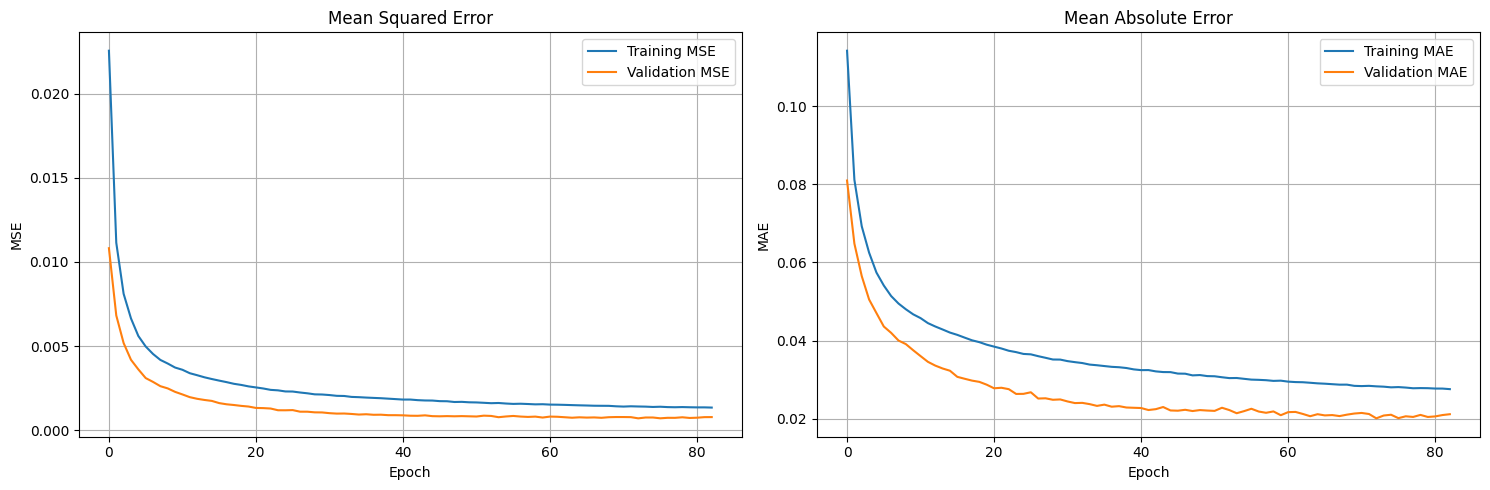

657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 720us/step

Validation R² score: 0.9858

Best validation results (epoch 73):
MSE: 0.000704
MAE: 0.020069
657/657 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step

Test R² score: 0.9889


In [5]:
# Train model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot MSE
ax1.plot(history.history['mse'], label='Training MSE')
ax1.plot(history.history['val_mse'], label='Validation MSE')
ax1.set_title('Mean Squared Error')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MSE')
ax1.legend()
ax1.grid(True)

# Plot MAE
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title('Mean Absolute Error')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MAE')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Calculate R² score on validation set
val_predictions = model.predict(X_val)
r2_val = r2_score(y_val, val_predictions)
print(f"\nValidation R² score: {r2_val:.4f}")

# Print best validation metrics
best_epoch = np.argmin(history.history['val_loss'])
print(f"\nBest validation results (epoch {best_epoch + 1}):")
print(f"MSE: {history.history['val_mse'][best_epoch]:.6f}")
print(f"MAE: {history.history['val_mae'][best_epoch]:.6f}")

# Evaluate on test set
test_predictions = model.predict(X_test)
r2_test = r2_score(y_test, test_predictions)
print(f"\nTest R² score: {r2_test:.4f}")

657/657 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step


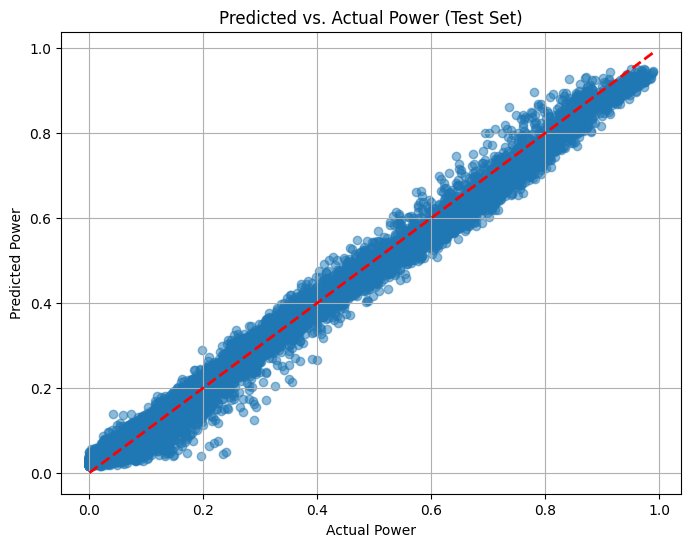

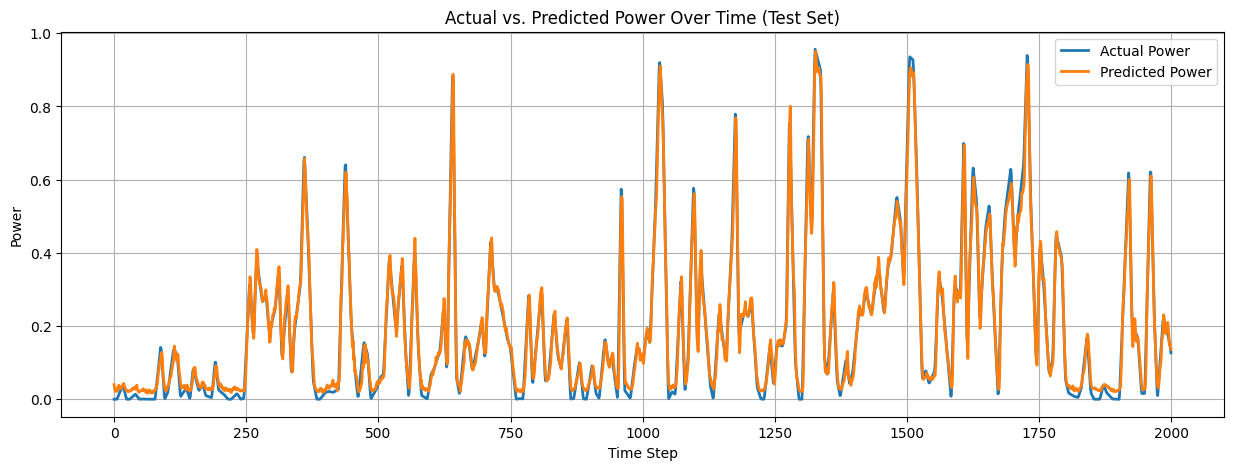

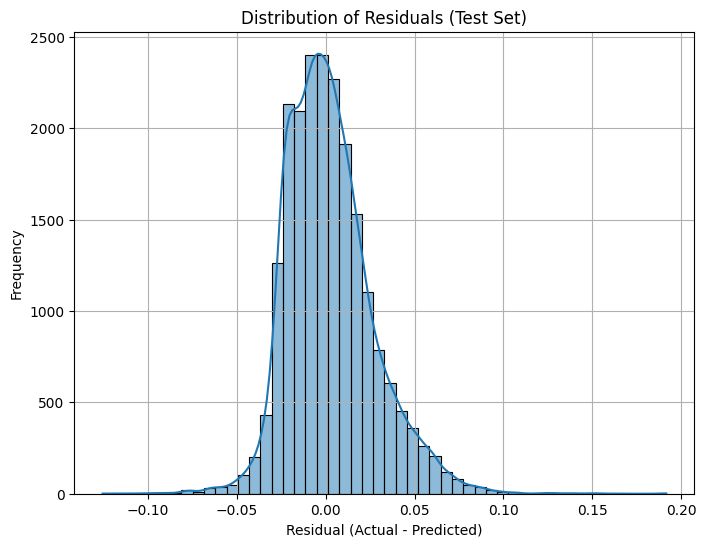


Test R² score: 0.9889

All results have been saved to the directory: ../results/run_20241107_164347


In [16]:
import os
import json
from datetime import datetime

# Create a unique directory for the results based on the current timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
results_dir = f'../results/run_{timestamp}'
os.makedirs(results_dir, exist_ok=True)

# 1. Use the test set for predictions
test_predictions = model.predict(X_test).squeeze()

# 2. Visualizations using the Test Set

## Scatter Plot: Predicted vs. Actual Values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, test_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Power')
plt.ylabel('Predicted Power')
plt.title('Predicted vs. Actual Power (Test Set)')
plt.grid(True)
plt.savefig(os.path.join(results_dir, 'predicted_vs_actual_scatter.png'))
plt.show()

## Line Chart: Actual vs. Predicted Values Over Time
# Select a small continuous portion of the data
start_idx = 0  # Adjust as needed
end_idx = start_idx + 2000

plt.figure(figsize=(15, 5))
plt.plot(range(start_idx, end_idx), y_test[start_idx:end_idx], label='Actual Power', linewidth=2)
plt.plot(range(start_idx, end_idx), test_predictions[start_idx:end_idx], label='Predicted Power', linewidth=2)
plt.xlabel('Time Step')
plt.ylabel('Power')
plt.title('Actual vs. Predicted Power Over Time (Test Set)')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(results_dir, 'actual_vs_predicted_over_time.png'))
plt.show()

## Distribution of Residuals
residuals = y_test - test_predictions
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=50)
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals (Test Set)')
plt.grid(True)
plt.savefig(os.path.join(results_dir, 'residuals_distribution.png'))
plt.show()

# 3. Save Model Weights and Architecture

## Save the model weights
model_weights_path = os.path.join(results_dir, 'model.weights.h5')
model.save_weights(model_weights_path)

## Save the model architecture to JSON
model_json = model.to_json()
model_architecture_path = os.path.join(results_dir, 'model_architecture.json')
with open(model_architecture_path, 'w') as json_file:
    json_file.write(model_json)

# 4. Save Training Parameters and History

## Save training parameters (hyperparameters)
training_params = {
    'optimizer': 'SGD',
    'learning_rate': 0.01,
    'momentum': 0.9,
    'loss_function': 'mse',
    'batch_size': 32,
    'epochs': len(history.history['loss']),
    'window_size': 12,
    'n_timesteps': n_timesteps,
    'n_features': n_features,
    'early_stopping_patience': 10,
    'train_size': X_train.shape[0],
    'validation_size': X_val.shape[0],
    'test_size': X_test.shape[0],
    'random_seed': 42,
}

training_params_path = os.path.join(results_dir, 'training_params.json')
with open(training_params_path, 'w') as f:
    json.dump(training_params, f, indent=4)

## Save training history
training_history_path = os.path.join(results_dir, 'training_history.json')
with open(training_history_path, 'w') as f:
    json.dump(history.history, f, indent=4)

# 5. Save Scaler Object

## Save the scaler used for data preprocessing
import joblib
scaler_path = os.path.join(results_dir, 'scaler.pkl')
joblib.dump(scaler, scaler_path)

# 6. Save Model Summary

## Capture the model summary to a text file
model_summary_path = os.path.join(results_dir, 'model_summary.txt')
with open(model_summary_path, 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

# 7. Log Final Evaluation Metrics on Test Set

## Calculate R² score on test set
r2_test = r2_score(y_test, test_predictions)
print(f"\nTest R² score: {r2_test:.4f}")

## Log the final evaluation metrics
evaluation_metrics = {
    'test_r2_score': float(r2_test),
    'best_epoch': int(best_epoch + 1),
    'best_val_loss': float(history.history['val_loss'][best_epoch]),
    'best_val_mse': float(history.history['val_mse'][best_epoch]),
    'best_val_mae': float(history.history['val_mae'][best_epoch]),
}

evaluation_metrics_path = os.path.join(results_dir, 'evaluation_metrics.json')
with open(evaluation_metrics_path, 'w') as f:
    json.dump(evaluation_metrics, f, indent=4)

# 9. Notify Completion and Results Directory
print(f"\nAll results have been saved to the directory: {results_dir}")